In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, f1_score, confusion_matrix

from sklearn.model_selection import KFold, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.display import Image
from IPython.display import YouTubeVideo
from IPython.display import HTML

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
HTML('''<script> code_show=true;  function code_toggle() { if (code_show){ $('div.input').hide(); } else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Show/Hide the raw code"></form>''')

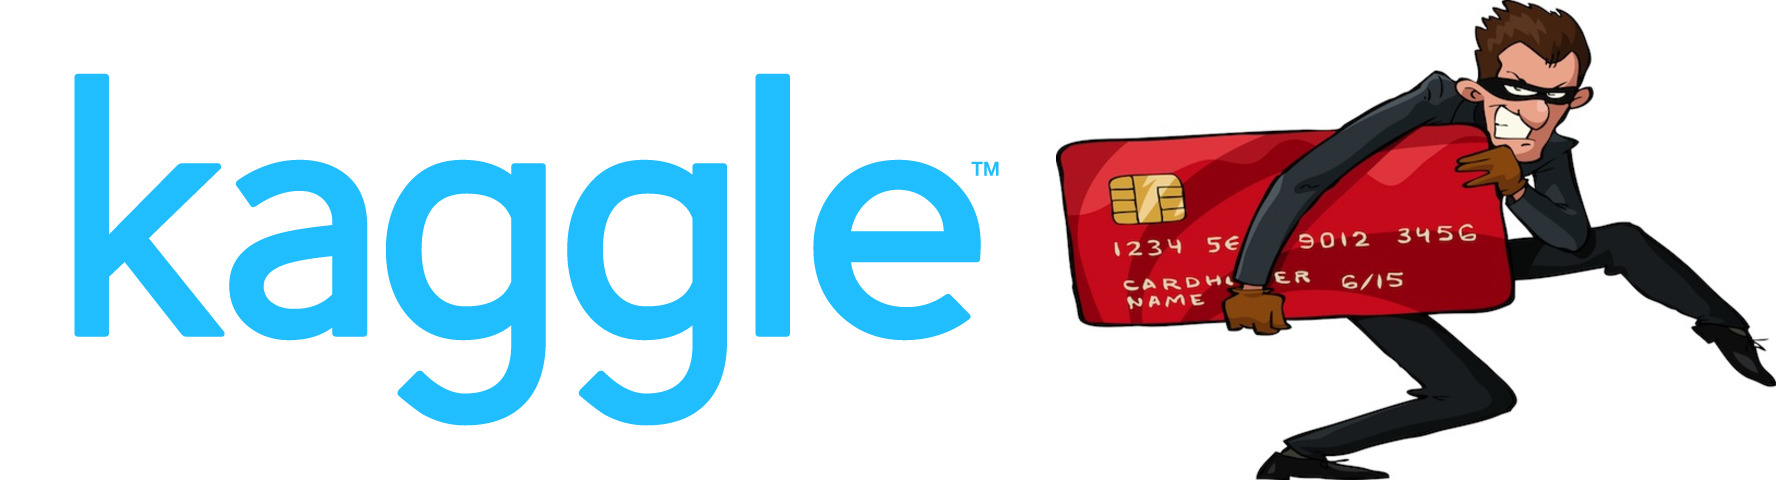

In [3]:
i = Image(filename=os.getcwd()+'/images/intro_image.jpg', width=950, height=900)
display(i)

# Credit Card Fraud Detection #
## Anonymized credit card transactions labeled as fraudulent or genuine ##

#### This notebook will test different classification methods on a Kaggle dataset of Credit Card Transactions (https://www.kaggle.com/dalpozz/creditcardfraud). ####
#### The idea is to compare if preprocessing techniques work better when there is an overwhelming majority class that can disrupt the efficiency of our predictive model. ####

In [4]:
# reading imputs
file = pd.read_csv("creditcard.csv")

Below is show the dataset sample, that 'V1'..'V28' are PCA features from a private dataset, the others features, 'Time','Amount' and 'Class' correspond to the transaction time, amount of it and the classification (0 for Normal transaction and 1 to Fraud transaction).

In [5]:
#Printing first 10 inputs

file.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [6]:
# Random value initilized
rand = np.random.RandomState(42)

def class_histogram():
    
    f, ax = plt.subplots(sharex=True, figsize=(15,7))
    count_classes = pd.value_counts(file['Class'], sort = True).sort_index()
    count_classes.plot(kind = 'bar')
    
    plt.title("Histogram (Normal and Fraud classes)")
    plt.xlabel("Class")
    plt.ylabel("Number of Transactions")
    plt.yscale('symlog')
    plt.show()
    
def plot_input_by_date(file, title, class_type, bins):

    f, ax = plt.subplots(sharex=True, figsize=(15,4))

    ax.hist(file.Time[file.Class == class_type], bins = bins)
    ax.set_title(title)

    plt.xlabel('Time (in Seconds)')
    plt.ylabel('Number of Transactions')
    plt.show()

def plot_input_by_amount(file, title, class_type, bins):    

    f, ax = plt.subplots(sharex=True, figsize=(15,4))

    ax.hist(file.Amount[file.Class == class_type], bins = bins)
    ax.set_title(title)

    plt.xlabel('Amount ($)')
    plt.ylabel('Number of Transactions')
    plt.show()

def plot_input_time_vs_amount(file, title, class_type):  

    f, ax = plt.subplots(sharex=True, figsize=(12,6))
    
    ax.scatter(file.Time[file.Class == class_type], file.Amount[file.Class == class_type])
    ax.set_title(title)

    plt.xlabel('Amount ($)')
    plt.ylabel('Number of Transactions')
    plt.show()

def fit_and_predict(name, model, data_train_X, data_train_Y, k):
    start = datetime.now()
    kfold = KFold(n_splits=k, shuffle=True, random_state=rand)
    
    predicted = cross_val_predict(model, data_train_X, data_train_Y, cv = kfold)
    recall = recall_score(data_train_Y, predicted)
    print("Execution Time {0}".format(datetime.now() - start))
    print("Recall Score for {0}: {1:.5f}".format(name, recall))
    print("F1 Score for {0}: {1:.5f}\n".format(name, f1_score(data_train_Y, predicted)))
    
    return recall,predicted

def index_from_higher_recall( vector ):
    for i, j in enumerate(vector):
        if j == max(vector):
            break
    return i

# Exploring the dataset by graphics

#### The Histogram graphic in log scale, shows how much biased to the Normal transaction it is.

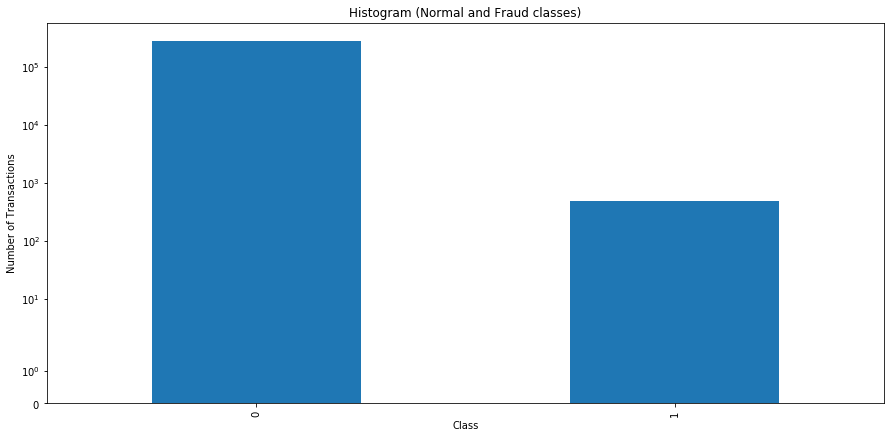

In [7]:
#Plotting Histogram (number of transactions from Normal and Fraud classes)
class_histogram()

#### These graphics represent the number of transaction per time for 2 days.

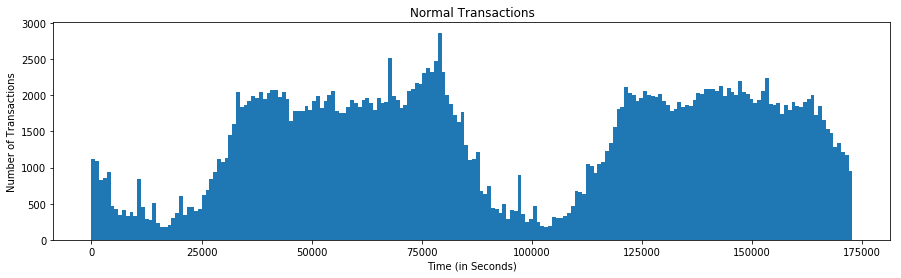

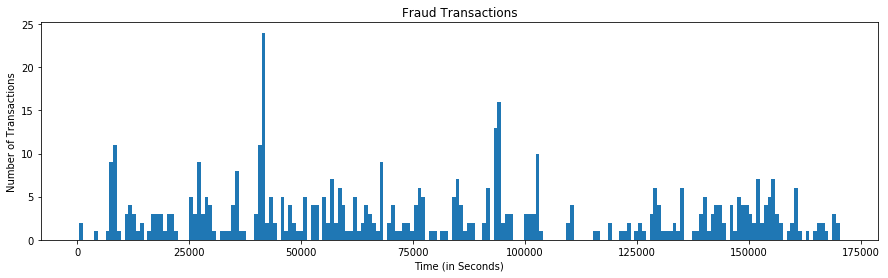

In [8]:
#Plotting graph Number of Normal Transactions vs Time
plot_input_by_date(file, title = "Normal Transactions", class_type = 0, bins = 200)

#Plotting graph Number of Fraud Transactions vs Time
plot_input_by_date(file, title = "Fraud Transactions", class_type = 1, bins = 200)

#### This graphic shows number to Normal and Fraud transactions per amount.
There shows that the high frequency is spotted to low amount values.

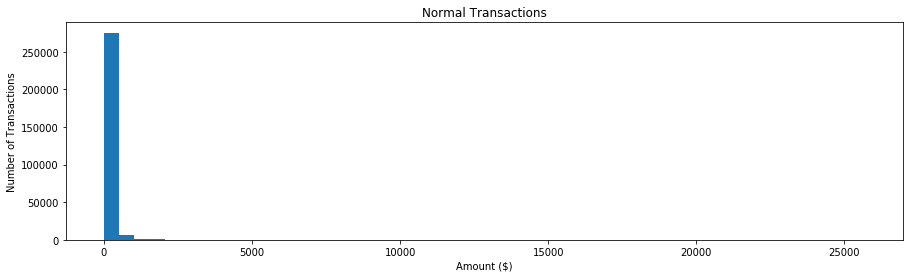

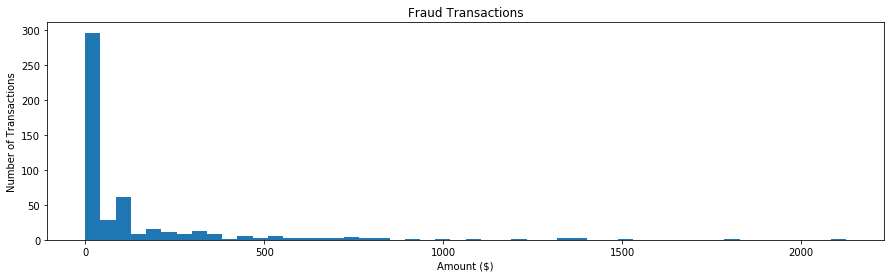

In [9]:
#Plotting graph Number of Normal Transactions vs Amount
plot_input_by_amount(file, title = "Normal Transactions", class_type = 0, bins = 50)

#Plotting graph Number of Fraud Transactions vs Amount
plot_input_by_amount(file, title = "Fraud Transactions", class_type = 1, bins = 50)

#### This graph shows how much deal per amount occured for Normal and Fraud transactions.

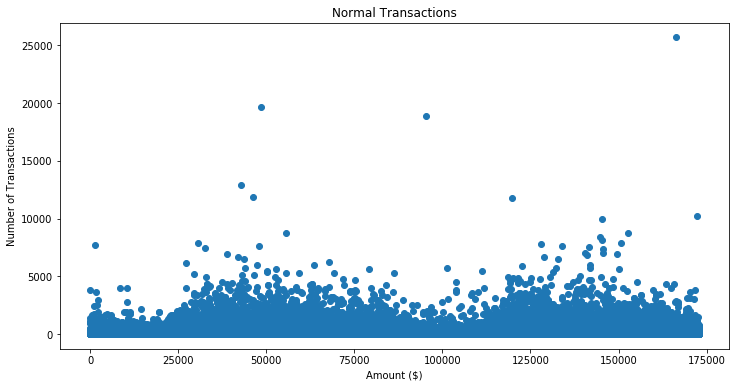

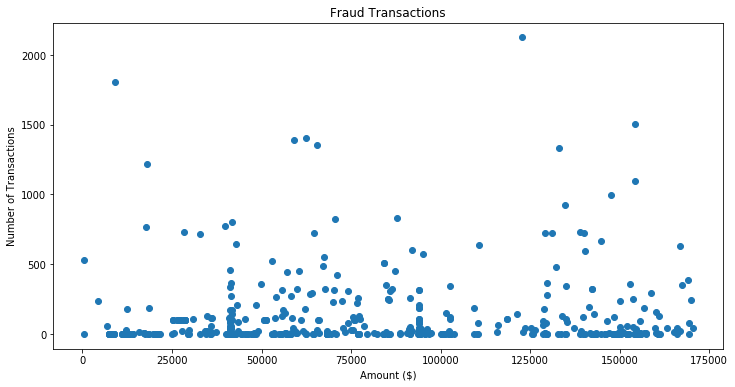

In [10]:
#Plotting graph Normal Time vs Amount
plot_input_time_vs_amount(file, title = "Normal Transactions", class_type = 0)

#Plotting graph Fraud Time vs Amount
plot_input_time_vs_amount(file, title = "Fraud Transactions", class_type = 1)

### Splitting data into train and test sets

In [11]:
#Splitting input into X (features contents) and Y (class type)
X = file.iloc[:, file.columns != 'Class']
Y = file.iloc[:, file.columns == 'Class']

#Split data with 70% for Train and 30% in test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = rand)

# Remove Time and Amount features **missing explanation**
X_train_dropped_features = X_train.drop(['Time', 'Amount'], axis = 1)
X_test_dropped_features = X_test.drop(['Time', 'Amount'], axis = 1)


print('Size of Train dataset {0}\nTrain sample'.format(X_train_dropped_features.shape))
X_train_dropped_features.head()

Size of Train dataset (199364, 28)
Train sample


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
2557,-2.289565,-0.480260,0.818685,-1.706423,0.822102,-1.660326,0.944047,-0.541765,1.323156,-0.434426,...,-0.401911,-0.831985,-0.210837,0.914737,0.867888,0.422969,0.310584,-0.781488,0.392241,-0.147757
247823,-0.313717,-4.064342,-3.398445,0.704011,0.101662,1.529848,1.551670,-0.036774,0.015829,-0.359561,...,-0.884600,2.142593,0.853186,-0.091941,-0.936215,-0.833081,-0.498728,0.651183,-0.290331,0.110360
152342,-1.809763,-0.567439,2.265186,-0.960318,-1.212537,1.516493,-1.417176,0.903421,1.961027,-0.724328,...,-0.464144,-0.554004,-0.509915,-0.424978,-0.268621,0.010121,0.466862,0.835540,-0.062385,0.088079
103385,1.192319,0.178575,0.141491,0.459628,-0.049959,-0.112122,-0.163883,0.155740,-0.067566,-0.130220,...,-0.137183,-0.149985,-0.240464,-0.739862,0.116799,-0.373837,0.125470,0.130126,-0.016956,0.011937
8771,-0.963451,0.700311,1.097333,-1.547626,0.669966,0.513533,0.333683,0.270900,1.381880,-0.659956,...,-0.470981,0.122458,-0.279519,-0.470181,-0.124037,-1.388839,-0.237453,0.785347,0.349708,0.216207


In [12]:
# Reshaping
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((len(Y_train),))

Y_test = np.array(Y_test)
Y_test = Y_test.reshape((len(Y_test),))

In [13]:
#List to preserve the best previous models
list_models_nn = []
list_recall_nn = []
list_models_lr = []
list_recall_lr = []
list_models_xgb = []
list_recall_xgb = []

# Logistic Regression exploration

A simple classifier function that was explored some parammeters for classification.

In [14]:
def lr_func_call():
    classes = ['ovr','multinomial']
    solvers = ['lbfgs', 'liblinear']
    c_v = [0.01,0.1,1,50,100]
    for cl in classes:
        for solv in solvers:
            for c in c_v:
                if solv == 'liblinear' and cl == 'multinomial':
                    continue
                else:
                    model_lr = LogisticRegression(multi_class=cl, solver=solv, random_state = rand, C = c)
                    recall,predicted = fit_and_predict('LogisticRegression', model_lr, X_train_dropped_features, Y_train ,5)
                    list_models_lr.append(model_lr)
                    list_recall_lr.append(recall)
                
lr_func_call()

Execution Time 0:00:02.704934
Recall Score for LogisticRegression: 0.58146
F1 Score for LogisticRegression: 0.70289

Execution Time 0:00:04.223818
Recall Score for LogisticRegression: 0.61236
F1 Score for LogisticRegression: 0.72305

Execution Time 0:00:04.869195
Recall Score for LogisticRegression: 0.60955
F1 Score for LogisticRegression: 0.71973

Execution Time 0:00:05.218461
Recall Score for LogisticRegression: 0.61236
F1 Score for LogisticRegression: 0.72185

Execution Time 0:00:05.389350
Recall Score for LogisticRegression: 0.60955
F1 Score for LogisticRegression: 0.71854

Execution Time 0:00:04.137175
Recall Score for LogisticRegression: 0.57584
F1 Score for LogisticRegression: 0.70085

Execution Time 0:00:05.786649
Recall Score for LogisticRegression: 0.59270
F1 Score for LogisticRegression: 0.70924

Execution Time 0:00:07.229545
Recall Score for LogisticRegression: 0.62079
F1 Score for LogisticRegression: 0.72697

Execution Time 0:00:07.412331
Recall Score for LogisticRegressio

# Exploring data with Neural Network

At this point we choosed Multi Layer Perceptron Classifier available in SKLearn framework to classify the Train data set.

The Neural Network schema will be choosed according with the best Recall result.

The MLPClassifier contains parameters and we choose to explore some of them as described below.

In [15]:
def nn_func_call():
    solvers = ['lbfgs','sgd','adam']
    activations = ['logistic','tanh','relu']
    hidden_layers_test = [(10,15),(15,27),(10,15,20),(15,27,49),(10,15,20,25)]

    for solv in solvers :
        for act in activations :
            for hid_l in hidden_layers_test :
                model_nn = MLPClassifier(activation = act, solver = solv, hidden_layer_sizes = hid_l, max_iter = 1000, random_state = rand)
                recall_result, predicted = fit_and_predict('MLPClassifier', model_nn, X_train_dropped_features, Y_train, 5)
                list_models_nn.append(model_nn)
                list_recall_nn.append(recall_result)
                
nn_func_call()

Execution Time 0:00:21.154426
Recall Score for MLPClassifier: 0.78652
F1 Score for MLPClassifier: 0.81752

Execution Time 0:00:33.391432
Recall Score for MLPClassifier: 0.78933
F1 Score for MLPClassifier: 0.82164

Execution Time 0:00:13.740333
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:23.909873
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:20.526636
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:33.374187
Recall Score for MLPClassifier: 0.76685
F1 Score for MLPClassifier: 0.80412

Execution Time 0:01:12.050008
Recall Score for MLPClassifier: 0.76404
F1 Score for MLPClassifier: 0.80236

Execution Time 0:02:10.046348
Recall Score for MLPClassifier: 0.73315
F1 Score for MLPClassifier: 0.80308

Execution Time 0:05:07.447755
Recall Score for MLPClassifier: 0.75281
F1 Score for MLPClassifier: 0.79881

Execution Time 0:04:56.285760
Recall Score for MLPClassifier: 0.76124
F1 Score for MLPClassifier: 0.77874

Execution Time 0:01:14.397584
Recall Score for MLPClassifier: 0.74719
F1 Score for MLPClassifier: 0.78466

Execution Time 0:02:08.840069
Recall Score for MLPClassifier: 0.75000
F1 Score for MLPClassifier: 0.77504

Execution Time 0:05:21.592139
Recall Score for MLPClassifier: 0.78371
F1 Score for MLPClassifier: 0.78371

Execution Time 0:05:41.790754
Recall Score for MLPClassifier: 0.79213
F1 Score for MLPClassifier: 0.78116

Execution Time 0:12:54.254423
Recall 

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:34.599323
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:42.046781
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:40.668335
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:52.633079
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:54.933227
Recall Score for MLPClassifier: 0.67416
F1 Score for MLPClassifier: 0.75591

Execution Time 0:01:06.139692
Recall Score for MLPClassifier: 0.71910
F1 Score for MLPClassifier: 0.78648

Execution Time 0:01:09.155747
Recall Score for MLPClassifier: 0.72472
F1 Score for MLPClassifier: 0.78539

Execution Time 0:01:25.088290
Recall Score for MLPClassifier: 0.72753
F1 Score for MLPClassifier: 0.78963

Execution Time 0:01:16.887033
Recall Score for MLPClassifier: 0.71629
F1 Score for MLPClassifier: 0.78101

Execution Time 0:00:40.954741
Recall Score for MLPClassifier: 0.00000
F1 Score for MLPClassifier: 0.00000



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Execution Time 0:00:48.656976
Recall Score for MLPClassifier: 0.70787
F1 Score for MLPClassifier: 0.78261

Execution Time 0:00:55.278966
Recall Score for MLPClassifier: 0.69944
F1 Score for MLPClassifier: 0.78179

Execution Time 0:01:58.034880
Recall Score for MLPClassifier: 0.66573
F1 Score for MLPClassifier: 0.75478

Execution Time 0:01:37.610891
Recall Score for MLPClassifier: 0.66854
F1 Score for MLPClassifier: 0.76038

Execution Time 0:00:52.306903
Recall Score for MLPClassifier: 0.79213
F1 Score for MLPClassifier: 0.81858

Execution Time 0:00:47.548762
Recall Score for MLPClassifier: 0.79494
F1 Score for MLPClassifier: 0.82148

Execution Time 0:01:03.885327
Recall Score for MLPClassifier: 0.78933
F1 Score for MLPClassifier: 0.81567

Execution Time 0:00:59.330841
Recall Score for MLPClassifier: 0.79213
F1 Score for MLPClassifier: 0.81503

Execution Time 0:01:17.028237
Recall Score for MLPClassifier: 0.79213
F1 Score for MLPClassifier: 0.80918

Execution Time 0:00:34.561948
Recall 

## New dataset approach
In this point will be test a new dataset approach, it will be resampled in a new dataset with 50/50 ratio (Normal and Fraud classes). 

This will be done by randomly selecting "x" amount of sample from the majority class, being "x" the total number of Fraud class records. 

Since the best model is already trained with an unbalanced dataset, this approach will try to force a 'balanced' fit to new weights for the best model.

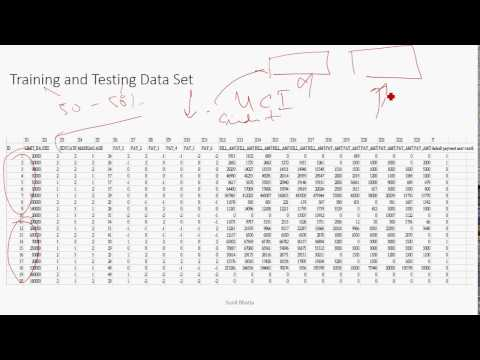

In [16]:
# a talk about Resampling Methods of datasets.
# Video credit: Sunil Bhatia
YouTubeVideo('nEn-SDcry9Y')

In [17]:
# Number of Fraud inputs
nb_frauds = len(file[file.Class == 1])

#Capturing Normal and Fraud index from input contents
fraud_index = np.array(file[file.Class == 1].index)
normal_index = file[file.Class == 0].index

# Selecting "nb_frauds" normal transactions from normal_index list
rd_normal_index = np.random.choice(normal_index, nb_frauds, replace = False)
# Transforming rd_normal_index into np.array

rd_normal_index = np.array(rd_normal_index)
# Concatenating Normal and Fraud index into one list of index (now, we have one list with same number for Normal and Fraud transactions)
sample_index = np.concatenate([fraud_index,rd_normal_index])
# Getting the "sample_data" of "sample_index" 
sample_data = file.iloc[sample_index,:]

#Splitting "sample_data" input into X (features contents) and Y (class type) 
X_sample = sample_data.iloc[:, sample_data.columns != 'Class']
Y_sample = sample_data.iloc[:, sample_data.columns == 'Class']

#Reshaping 1d vector
Y_sample = np.array(Y_sample)
Y_sample = Y_sample.reshape((len(Y_sample),))

# Showing ratio
print("Sample db details:")
print("Total of transactions:", len(sample_data))
print("% of Normal transactions: ", 100*len(sample_data[sample_data.Class == 0])/len(sample_data))
print("% of Fraud transactions: ", 100*len(sample_data[sample_data.Class == 1])/len(sample_data))


Sample db details:
Total of transactions: 984
% of Normal transactions:  50.0
% of Fraud transactions:  50.0


In [18]:
index = index_from_higher_recall(list_recall_nn)
best_model_nn = list_models_nn[index]
rec, pred = fit_and_predict('MLPClassifier', best_model_nn, X_sample, Y_sample, 5)

Execution Time 0:00:00.124451
Recall Score for MLPClassifier: 0.37602
F1 Score for MLPClassifier: 0.41761



# Exploring data with XGBClassifier

According to the nschneider's kernel (https://www.kaggle.com/nschneider/gbm-vs-xgboost-vs-lightgbm?scriptVersionId=1508193), the XGBoost is a good method to explore this kind of data and we also choosed this as a one approach way, looking for high recall value for the best parameters for XGBClassifier method.

    XGBoost classifier Tree - Model Explained 
    http://xgboost.readthedocs.io/en/latest/model.html

    XGBoost API docs
    http://xgboost.readthedocs.io/en/latest/python/python_api.html

In [19]:
def xgboost_func():
    m_depth = [3,5,7]
    learning_rate = [0.01,0.1,1]
    booster_vet =['gbtree', 'gblinear', 'dart']
    for depth in m_depth:
        for lr in learning_rate:
            for boost in booster_vet:
                model = XGBClassifier(max_depth = depth, learning_rate = lr, booster = boost, nthread = 4, random_state = 1)
                recall, predicted = fit_and_predict('XGBClassifier', model, X_train_dropped_features, Y_train, 5)
                list_models_xgb.append(model)
                list_recall_xgb.append(recall)
                
xgboost_func()

Execution Time 0:00:41.545726
Recall Score for XGBClassifier: 0.72753
F1 Score for XGBClassifier: 0.78248

Execution Time 0:00:08.804447
Recall Score for XGBClassifier: 0.40730
F1 Score for XGBClassifier: 0.54924

Execution Time 0:00:52.825490
Recall Score for XGBClassifier: 0.72753
F1 Score for XGBClassifier: 0.78366

Execution Time 0:00:41.936147
Recall Score for XGBClassifier: 0.76404
F1 Score for XGBClassifier: 0.83053

Execution Time 0:00:08.795027
Recall Score for XGBClassifier: 0.60112
F1 Score for XGBClassifier: 0.71812

Execution Time 0:00:59.116544
Recall Score for XGBClassifier: 0.75281
F1 Score for XGBClassifier: 0.82844

Execution Time 0:00:38.545264
Recall Score for XGBClassifier: 0.77247
F1 Score for XGBClassifier: 0.85139

Execution Time 0:00:08.812171
Recall Score for XGBClassifier: 0.60393
F1 Score for XGBClassifier: 0.71429

Execution Time 0:01:02.048508
Recall Score for XGBClassifier: 0.75843
F1 Score for XGBClassifier: 0.84243

Execution Time 0:01:01.520540
Recall 

### Best LR Model

In [27]:
index_lr = index_from_higher_recall(list_recall_lr)
print('Model: {0}'.format(list_models_lr[index_lr]))
print('Recall result: {0}'.format(list_recall_lr[index_lr]))

Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2',
          random_state=<mtrand.RandomState object at 0x1094c9438>,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Recall result: 0.6207865168539326


### Best NN Model

In [28]:
index_nn = index_from_higher_recall(list_recall_nn)
print('Model: {0}'.format(list_models_nn[index_nn]))
print('Recall result: {0}'.format(list_recall_nn[index_nn]))

Model: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 27), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5,
       random_state=<mtrand.RandomState object at 0x1094c9438>,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Recall result: 0.7949438202247191


### Best XGBClassifier Model

In [29]:
index_xgb = index_from_higher_recall(list_recall_xgb)
print('Model: {0}'.format(list_models_xgb[index_xgb]))
print('Recall result: {0}'.format(list_recall_xgb[index_xgb]))

Model: XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Recall result: 0.7837078651685393


# Test result
After choosed the best method according to the previous results, it's time to apply the final test for it.

In [30]:
best = None
if  list_recall_lr[index_lr] > list_recall_nn[index_nn] and list_recall_lr[index_lr] > list_recall_xgb[index_xgb]:
    best = list_models_lr[index_lr]
elif  list_recall_nn[index_nn] > list_recall_lr[index_lr] and list_recall_nn[index_nn] > list_recall_xgb[index_xgb]:
    best = list_models_nn[index_nn]
else :
    best = list_models_xgb[index_xgb]
    
predicted_test = fit_and_predict('Best Model', best ,X_test_dropped_features, Y_test, 5)

Execution Time 0:00:41.563653
Recall Score for Best Model: 0.80882
F1 Score for Best Model: 0.81481



In [31]:
#Plot confusion matrix
import itertools

def cf_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

The final result is showed above for a non-normalized confusion matrix.

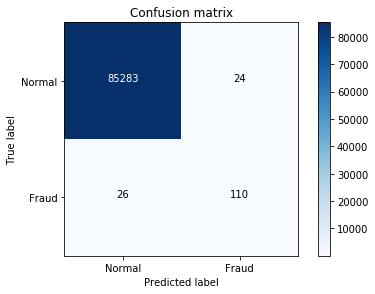

In [38]:
#Plot non-normalized confusion matrix

class_names = ['Normal','Fraud']
cf_mat = confusion_matrix(Y_test, predicted_test[1])
cf_matrix(cf_mat, classes=class_names)